# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

In [4]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [5]:
%%px --local

import sys
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis")
from cityanalysis import City
from cityanalysis import fractal_dimension


In [6]:
%%px --local 

from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None, scale=False, thresh=0):
    img = imread(f)
    img[img<thresh] = 0
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    if scale:
        img = (img - img.min()) / float((img.max() - img.min()))
    return img

# Show stats on one example

First example: Paris, a radial, landlocked city with some lakes around.

In [7]:
myfile_SAR = '/home/data/world-cities/spatial-maps/raw/SAR_united-states_california_san-francisco_medium_930370_37.7554_-122.4433.tif'
myfile_POP = '/home/data/world-cities/spatial-maps/raw/POP_united-states_california_san-francisco_medium_930370_37.7554_-122.4433.tif'
myfile_NLI = '/home/data/world-cities/spatial-maps/raw/NLI_united-states_california_san-francisco_medium_930370_37.7554_-122.4433.tif'
myfile_BND = '/home/data/world-cities/spatial-maps/raw/BND_united-states_california_san-francisco_medium_930370_37.7554_-122.4433.tif'
myfile_WTR = '/home/data/world-cities/spatial-maps/raw/WTR_united-states_california_san-francisco_medium_930370_37.7554_-122.4433.tif'
cityname = "San Francisco"

In [8]:
myfile_SAR = '/home/data/world-cities/spatial-maps/raw/SAR_france_ledefrance_paris_large_2483601_48.8566_2.3423.tif'
myfile_POP = '/home/data/world-cities/spatial-maps/raw/POP_france_ledefrance_paris_large_2483601_48.8566_2.3423.tif'
myfile_NLI = '/home/data/world-cities/spatial-maps/raw/NLI_france_ledefrance_paris_large_2483601_48.8566_2.3423.tif'
myfile_BND = '/home/data/world-cities/spatial-maps/raw/BND_france_ledefrance_paris_large_2483601_48.8566_2.3423.tif'
myfile_WTR = '/home/data/world-cities/spatial-maps/raw/WTR_france_ledefrance_paris_large_2483601_48.8566_2.3423.tif'
cityname = "Paris"

In [9]:
img = []
for f in [myfile_SAR, myfile_POP, myfile_NLI]:
    img.append(read_img(f))
img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)
   
bounds = read_img(myfile_BND)
mask = read_img(myfile_WTR,scale=True)

mycity = City(img, name=cityname, mask=mask, bounds=bounds, 
              sources=["built", "pop", "lum"])

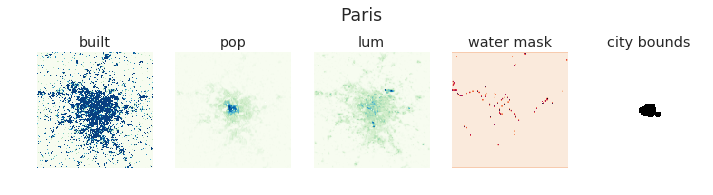

In [10]:
sns.set_context("notebook", font_scale=1.2)

fig, ax = plt.subplots(1,len(mycity.sources)+2,figsize=(12,3))
for i,s in enumerate(mycity.sources):
    ax[i].imshow(mycity.M[...,i], cmap=cm.GnBu); 
    ax[i].axis("off"); ax[i].set_title(s)

ax[len(mycity.sources)].imshow(mycity.mask); 
ax[len(mycity.sources)].axis("off"); 
ax[len(mycity.sources)].set_title("water mask")
# overlay_mask(mycity.mask, mycity.bounds, ax[1])

ax[len(mycity.sources)+1].imshow(mycity.bounds, cmap=cm.Greys); 
ax[len(mycity.sources)+1].axis("off"); 
ax[len(mycity.sources)+1].set_title("city bounds")

fig.suptitle(mycity.name)

#### Fraction of occupied area

In [11]:
mycity.compute_average(within_bounds=True)
mycity.avg_areas_bnds

{'built': 0.85263030709735788,
 'lum': 69.038634451411582,
 'pop': 10858.239366079104}

In [12]:
mycity.compute_average(within_bounds=False)
mycity.avg_areas

{'built': 0.19758176985200884,
 'lum': 10.305298755209732,
 'pop': 709.25825800400685}

In [13]:
mycity.sum_areas

{'built': 3236.9821354854607,
 'lum': 168831.70950660104,
 'pop': 11619778.040879644}

#### Distribution of patch areas

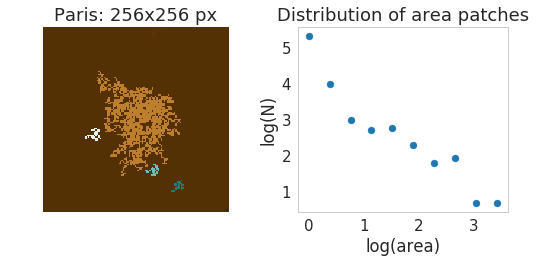

In [14]:
sns.set_context("notebook", font_scale=1.5)

mycity.compute_regions()
areas = mycity.regions['built']
areas_distr, bins = mycity.areas_distr['built'][0], mycity.areas_distr['built'][1]

# plot just top 5 areas
mask1 = mycity.masks_regions['built'].copy()
for a in areas[5:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("%s: 256x256 px" % mycity.name)
ax[0].axis("off")

# plot distribution of area sizes
ax[1].scatter(np.log(bins), areas_distr, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

plt.tight_layout()

#### Fractal dimension

('Minkowski-Bouligand dimension (computed): ', nan)
('Haussdorf dimension (theoretical):        ', 1.5849625007211563)


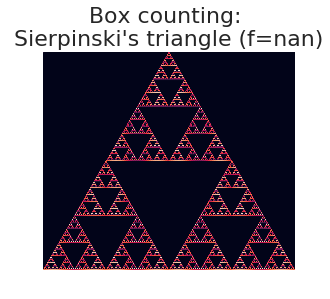

In [15]:
I = read_img("sierpinski.png")
plt.imshow(1-I)
plt.axis("off")
plt.title("Box counting: \nSierpinski's triangle (f=%2.2f)"%fractal_dimension(I)[0], 
          fontsize=22)

print("Minkowski-Bouligand dimension (computed): ", fractal_dimension(I)[0])
print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))

In [16]:
frac_dim = mycity.compute_fractal_dim(0, within_bounds=False)
print mycity.fractal_dim

_, log_box_sizes, log_box_counts = fractal_dimension(mycity.M[:,:,0])

{'built': 1.9575805118782876}


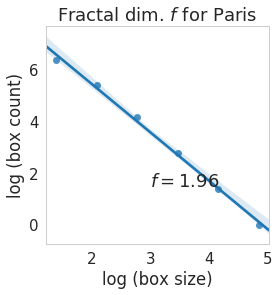

In [17]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(4,4))
ax = sns.regplot(log_box_sizes, log_box_counts, lowess=False)
plt.xlabel("log (box size)")
plt.ylabel("log (box count)")
plt.title("Fractal dim. $f$ for %s" % mycity.name)

ax.annotate('$f=$%.2f'%frac_dim['built'], xy=(2, 1), xytext=(3, 1.5))


#### Compute distance profiles

48


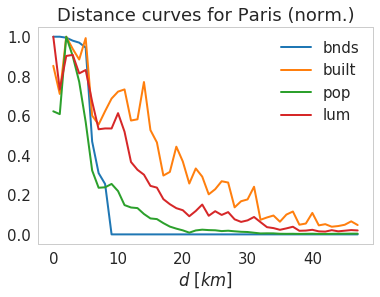

In [18]:
profiles = mycity.compute_profile(method="raysampling", step=1.34, bounds_layer=True)

L = len(profiles.values()[0][0])
print L
xlabels = np.arange(L)

plt.figure(figsize=(6,4))
for c,p in profiles.iteritems():
    plt.plot(xlabels, p[0]/np.nanmax(p[0]), label=c, lw=2)
plt.legend(loc="best")
plt.title("Distance curves for %s (norm.)"%mycity.name)
plt.xlabel("$d \ [km]$")

48


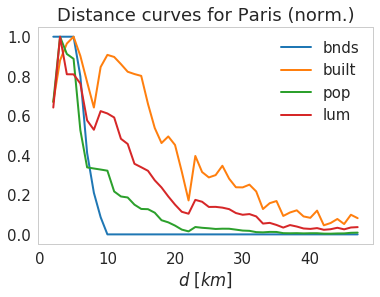

In [19]:
# using radial estimation method

profiles = mycity.compute_profile(method="radial", step=1.34, bounds_layer=True)

L = len(profiles.values()[0][0])
print L
xlabels = np.arange(L)

plt.figure(figsize=(6,4))
for c,p in profiles.iteritems():
    plt.plot(xlabels, p[0]/np.nanmax(p[0]), label=c, lw=2)
plt.legend(loc="best")
plt.title("Distance curves for %s (norm.)"%mycity.name)
plt.xlabel("$d \ [km]$")

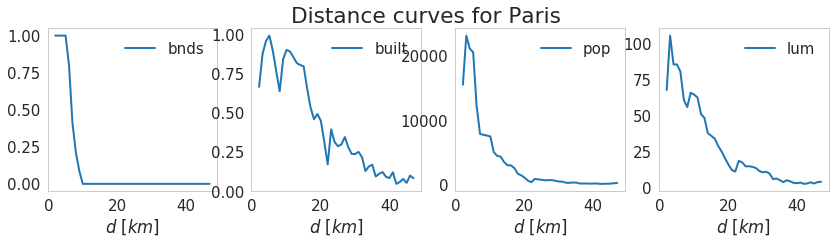

In [20]:
# using radial estimation method 

profiles = mycity.compute_profile(method="radial", step=1.34)

L = len(profiles.values()[0][0])
xlabels = np.arange(L)

fig, ax = plt.subplots(1,4,figsize=(14,3))
for (c,p),a in zip(profiles.iteritems(),ax):
    a.plot(xlabels, p[0], label=c, lw=2)
    a.set_xlabel("$d \ [km]$")
    a.legend(loc="best")
fig.suptitle("Distance curves for %s"%mycity.name)

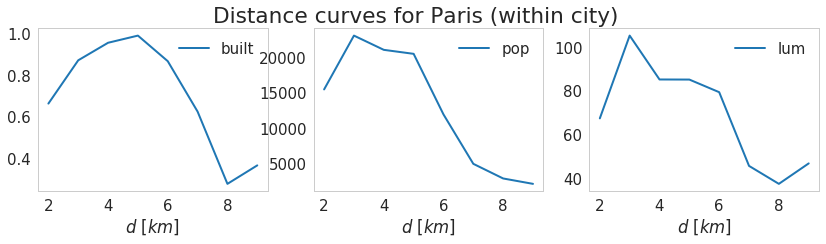

In [21]:
# using radial estimation method 

profiles = mycity.compute_profile(method="radial", step=1.333, within_bounds=True)

L = len(profiles.values()[0][0])
xlabels = np.arange(L)

fig, ax = plt.subplots(1,3,figsize=(14,3))
for (c,p),a in zip(profiles.iteritems(),ax):
    a.plot(xlabels, p[0], label=c, lw=2)
    a.set_xlabel("$d \ [km]$")
    a.legend(loc="best")
fig.suptitle("Distance curves for %s (within city)"%mycity.name)

# Compute spatial stats across all cities

#### Gather all data sources

In [22]:
import csv, sys

csv.field_size_limit(sys.maxsize)

# note keep_default_na=False: there are cities/provinces that are actually 
# called 'nan', and pandas interprets them as NaN values
cities_df = pd.read_csv("/home/data/world-cities/cities_over_10kpop.csv", 
                        engine='python', keep_default_na=False, 
                        usecols=["city", "province", "country", "countrycode", "area", "scale", "location", "region", "subregion", "population", "size"])

In [23]:
import geojson
from shapely.geometry import shape
from shapely.wkt import loads

parse_location = lambda s: shape(loads(s))
point2loc = lambda p: tuple(np.array(p.centroid.coords.xy).squeeze())

In [24]:
city_info = []
for i,(idx,r) in enumerate(cities_df.iterrows()):
    if i % 100 ==0:
        clear_output(wait=True)
        print "city %d/%d" % (i, len(cities_df))

    lonlat = parse_location(r['location'])
    imgLat, imgLon = point2loc(lonlat)[::-1]
    city, province, country = r['city'].replace(" ","-"), r['province'].replace(" ","-"), r['country'].strip().replace(" ","-")
    popNum, popClass = int(r['population']), r['size'].replace(" ","-")
                       
    # save city info to file
    sample_name = "%s_%s_%s_%s_%d_%2.4f_%2.4f"%(country, province, city, popClass, popNum, imgLat, imgLon)
    info = r[['city', 'country', 'region', 'subregion', 'population', 'size', 'area', 'scale']].to_dict()
    city_info += [(sample_name, info)]

city 29800/29850


#### Compute stats in parallel

In [25]:
%%px --local

import numpy as np
import os
import cPickle as pickle
import gzip
from skimage.io import imsave

input_path = "/home/data/world-cities/spatial-maps/raw" 
samples_path = "/home/data/world-cities/spatial-maps/samples"

if not os.path.exists(samples_path):
    os.makedirs(samples_path)

def compute_stats_and_save(sample_info, save_dir=None):
    sample_name, basic_info = sample_info
    # check that all filenames exist
    src_vec = ['SAR', 'POP', 'NLI']
    file_names = ["%s/%s_%s.tif"%(input_path,src,sample_name) 
                  for src in src_vec]
    file_names = [f for f in file_names if os.path.exists(f)]
    if len(file_names)<len(src_vec):
        return None
    
    # load in image data
    img = []
    thresh = [0, 10, 0.1]
    for f,t in zip(file_names, thresh):
        img.append(read_img(f, thresh=t))
    img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)
    mask = read_img("%s/WTR_%s.tif"%(input_path,sample_name), scale=True)
    bnds = read_img("%s/BND_%s.tif"%(input_path,sample_name))
    
    # compute stats
    city = City(img, mask=mask, bounds=bnds, name=sample_name, 
                sources=["bldg", "pop", "lum"])
    try:
        city.analyze(step=1.34)
        city.analyze(step=1.34, within_bounds=True)
    except:
        return None
    stats = {"profiles":{k:(np.nan_to_num(v[0]), np.nan_to_num(v[1]))\
                         for k,v in city.profiles.iteritems()}, 
             "profiles bnds":{k:(np.nan_to_num(v[0]), np.nan_to_num(v[1]))\
                         for k,v in city.profiles_bnds.iteritems()}, 
             "frac dim":city.fractal_dim, 
             "frac dim bnds":city.fractal_dim_bnds, 
             "avg area":city.avg_areas, 
             "sum area":city.sum_areas, 
             "avg area bnds":city.avg_areas_bnds, 
             "sum area bnds":city.sum_areas_bnds, 
             "area dis":city.areas_distr,
             "area dis bnds":city.areas_distr_bnds,
            }
    all_info = dict(basic_info.items() + stats.items())
    
    # save data if requested
    if save_dir is not None:
        # save sample info
        info_file = "%s/%s.pickle.gz" % (save_dir, sample_name)
        with gzip.open(info_file, "w") as f:
            pickle.dump(all_info, f)
        # save sample data
        img_out = np.concatenate([city.M, city.mask[...,np.newaxis], city.bounds[...,np.newaxis]], axis=2)
        img_out = np.nan_to_num(img_out)
        data_file = "%s/%s.tif" % (save_dir, sample_name)
        imsave(data_file, img_out)
    
    # return info
    return all_info

In [ ]:
# test saving and reloading data
k = [(k,v) for (k,v) in city_info if 'san-francisco' in k and 'california' in k][0]
k

# i = 900
# k = city_info[i]
info = compute_stats_and_save(k, save_dir=samples_path)

from skimage.io import imread

tmp = imread(samples_path + "/" + k[0] + ".tif")
print tmp.shape
print k

In [ ]:
info['profiles'].keys()

In [ ]:
%%timeit
info = compute_stats_and_save(city_info[i])

In [ ]:
res = lbv.map_async(lambda src: compute_stats_and_save(src, save_dir=samples_path), 
                    city_info)


In [ ]:
res.progress

#### Also save city statistics as a single file 

In [ ]:
idx_ok = [r is not None for _,r in enumerate(res.result()) ]
cities = dict(zip([i[0] for i,ok in zip(city_info, idx_ok) if ok], 
         [dict(i[1].items() + d.items()) for i,d,ok in zip(city_info,res.result(), idx_ok) if ok]))

print len(idx_ok), sum(idx_ok)

with gzip.open("/home/data/world-cities/spatial-maps/stats_cities_over10kpop.pickle.gz", "w") as f:
    pickle.dump(cities, f)
    
L = len(cities.values()[0]['profiles']['bldg'][0]) # length of profile in km
distance_km = np.arange(L)

# Analyze spatial statistics over all cities 

In [26]:
colormap = {"bldg":"black", "pop":"green", "lum":"orange", 
            "all":"blue", "bnds":"gray"}

In [27]:
with gzip.open("/home/data/world-cities/spatial-maps/stats_cities_over10kpop.pickle.gz", "r") as f:
    cities = pickle.load(f)
    
L = len(cities.values()[0]['profiles']['bldg'][0]) # length of profile in km
distance_km = np.arange(L)

Average built area $a$

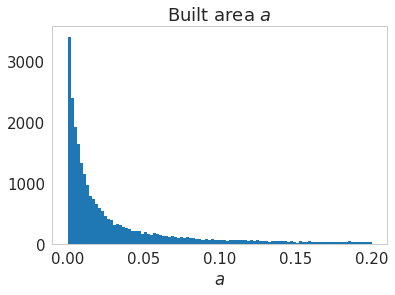

In [28]:
a_sar = np.array([v['avg area']['bldg'] for k,v in cities.iteritems() if not np.isnan(v['frac dim']['bldg'])])
a_sar_bnds = np.array([v['avg area bnds']['bldg'] for k,v in cities.iteritems() if not np.isnan(v['frac dim']['bldg'])])

sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
_ = plt.hist(a_sar_bnds, bins=100, range=(0,0.2))
plt.title("Built area $a$")
plt.xlabel("$a$")

Fractal dimension $f$

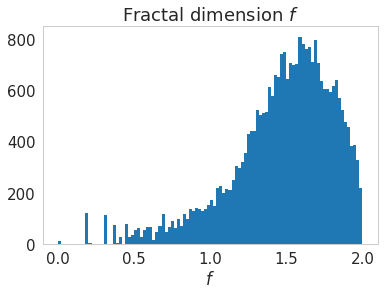

In [29]:
f_sar = np.array([v['frac dim']['bldg'] for k,v in cities.iteritems() if not np.isnan(v['frac dim']['bldg'])])

sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
_ = plt.hist(f_sar, bins=100)
plt.title("Fractal dimension $f$")
plt.xlabel("$f$")

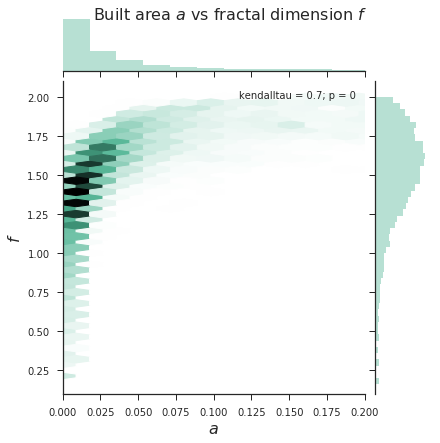

In [30]:
from scipy.stats import kendalltau
sns.set_context("notebook", font_scale=1.5)
sns.set(style="ticks")

plt.figure(figsize=(6,4))
g = sns.jointplot(a_sar, f_sar, xlim=(0,0.2), ylim=(0.1,2.1),
              kind="hex", stat_func=kendalltau, color="#4CB391")
g.fig.suptitle("Built area $a$ vs fractal dimension $f$", fontsize=16)
g.ax_joint.set_xlabel("$a$", fontsize=16)
g.ax_joint.set_ylabel("$f$", fontsize=16)

In [31]:
profile_bld = np.array([v['profiles']['bldg'][0] for k,v in cities.iteritems()])
profile_lum = np.array([v['profiles']['lum'][0] for k,v in cities.iteritems()])
profile_pop = np.array([v['profiles']['pop'][0] for k,v in cities.iteritems()])

profile_bld.shape

(29850, 48)

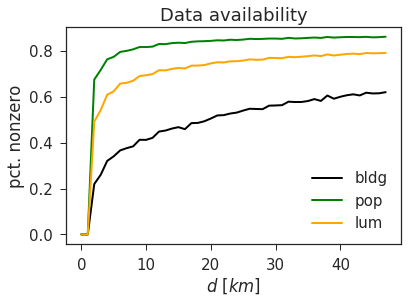

In [32]:
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))

plt.plot(distance_km, (profile_bld>0).mean(0), label="bldg", lw=2, color=colormap['bldg'])
plt.plot(distance_km, (profile_pop>0).mean(0), label="pop", lw=2, color=colormap['pop'])
plt.plot(distance_km, (profile_lum>0).mean(0), label="lum", lw=2, color=colormap['lum'])
plt.title("Data availability")
plt.xlabel("$d \ [km]$")
plt.ylabel("pct. nonzero")
plt.legend(loc="best")

# Analyze several examples in detail

#### Examples of spatial profiles to describe cities

In [33]:
mycities = [("paris", "france"), 
            ("rio de janeiro", "brazil"), 
            ("san francisco", "united states"), 
            ("barcelona", "spain"),
            ("mumbai city", "india"), 
            ("shanghai", "china")]

cities_smpl = {}
for c in mycities:
    for k,v in cities.iteritems():
        if v['city'] == c[0] and v['country']== c[1]:
            cities_smpl[v['city']] = (v,k)
            break
        
colormap_cities = dict(zip(cities_smpl.keys(), 
                           sns.color_palette("Set2", len(mycities))))

#### Raw profiles and average spatial gradient estimation

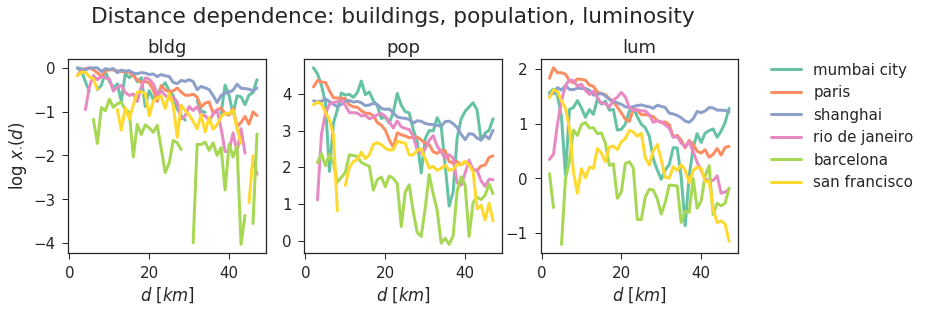

In [34]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(1,3, figsize=(12,4), gridspec_kw={"wspace":0.195, "hspace":0.5},
                      sharex=True, sharey=False)

for j,s,a in zip(range(len(cities_smpl)),['bldg', 'pop', 'lum'],ax.flatten()):
    for k,(v,_) in cities_smpl.iteritems():
        mu = v['profiles'][s][0]
        a.plot(distance_km, np.log10(mu), lw=3, color=colormap_cities[k],
               label=v['city'])
    a.set_title(s)
    if j == 0:
        a.set_ylabel("log $x_{\cdot}(d)$")
    a.set_xlabel("$d \ [km]$")
 
a.legend(loc="best", bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: buildings, population, luminosity")

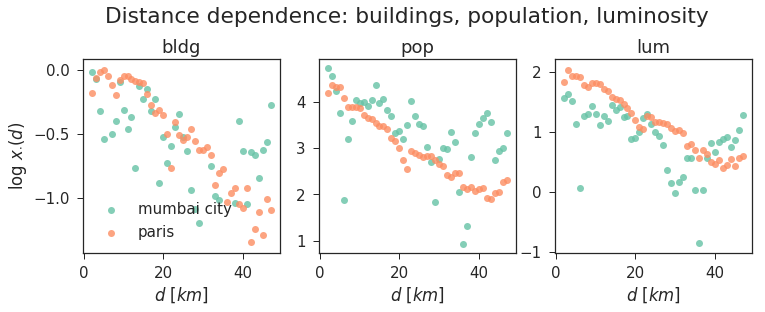

In [35]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(1,3, figsize=(12,4), gridspec_kw={"wspace":0.195, "hspace":0.5},
                      sharex=True, sharey=False)

for j,s,a in zip(range(len(cities_smpl)),['bldg', 'pop', 'lum'],ax.flatten()):
    for i,k in enumerate(cities_smpl.keys()[:2]):
        v = cities_smpl[k][0]
        mu = v['profiles'][s][0]
        sns.regplot(distance_km, np.log10(mu), ax=a, fit_reg=True,
                   label=v['city'], color=colormap_cities[k])
        a.set_title(s)
    if j == 0:
        a.set_ylabel("log $x_{\cdot}(d)$")
        a.legend(loc="best")# bbox_to_anchor=(1.1, 1.05))
    a.set_xlabel("$d \ [km]$")
 
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence: buildings, population, luminosity")

#### Normalized profiles

As the plots below show, it looks like there are some strong differences between (normalized) population, built environment, and luminosity (energy use/economic activity) for the example cities. Some cities like Lagos have spread out population, but lower luminosity and building density, whereas the population and luminosity for Boston are more or less in sync. 

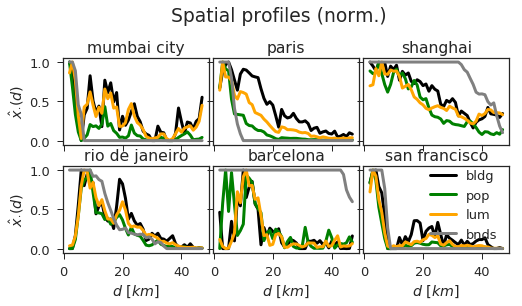

In [36]:
sns.set_context("notebook", font_scale=1.3)
fig, ax = plt.subplots(2,3, figsize=(8,4), gridspec_kw={"wspace":0.03, "hspace":0.25},
                      sharex=True, sharey=True)

for j,(k,(v,_)),a in zip(range(len(cities_smpl)),cities_smpl.iteritems(), ax.flatten()):
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = v['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        a.plot(distance_km[2:], mu / scale, lw=3, label=s, color=colormap[s])
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("$\hat x_{\cdot}(d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Spatial profiles (norm.)")

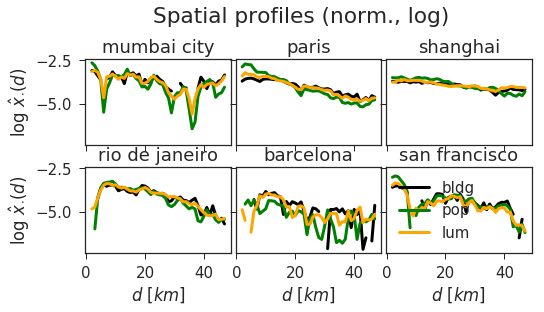

In [37]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(8,4), gridspec_kw={"wspace":0.03, "hspace":0.25},
                      sharex=True, sharey=True)

for j,(k,(v,_)),a in zip(range(len(cities_smpl)),cities_smpl.iteritems(), ax.flatten()):
    for s in ['bldg', 'pop', 'lum']:
        mu = v['profiles'][s][0]
        scale = v['sum area'][s]
        a.plot(distance_km, np.log10(mu / scale), lw=3, label=s, color=colormap[s])
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("log $\hat x_{\cdot}(d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Spatial profiles (norm., log)")

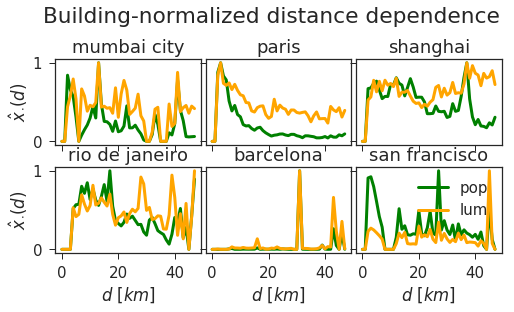

In [38]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(8,4), 
                       gridspec_kw={"wspace":0.03, "hspace":0.25},
                       sharex=True, sharey=True)

for j,(k,(v,_)),a in zip(range(len(cities_smpl)),cities_smpl.iteritems(), ax.flatten()):
    for s in ['pop', 'lum']:
        mu = v['profiles'][s][0]
        bl = v['profiles']['bldg'][0]
        mu = mu / bl
        mu[np.isnan(mu) | np.isinf(mu)]=0
        a.plot(distance_km, mu / mu.max(), lw=3, label=s, color=colormap[s])
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("$\hat x_{\cdot}(d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Building-normalized distance dependence")

But the curves $x_\cdot(d)$ above are the $\textit{average}$ profiles. The variance around these averages can be significant, as shown in the figures below. Note that the variance seems to increase with distance, which is to be expected, given that farther out from the city center there can be many different types of sprawl.

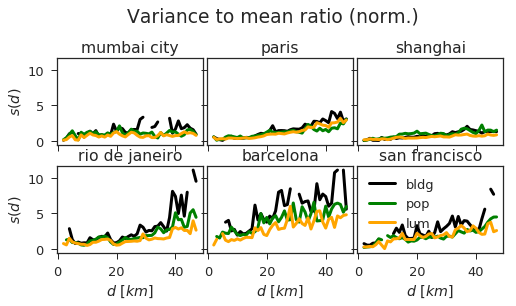

In [39]:
sns.set_context("notebook", font_scale=1.3)
fig, ax = plt.subplots(2,3, figsize=(8,4), gridspec_kw={"wspace":0.03, "hspace":0.25},
                      sharex=True, sharey=True)

for j,(k,(v,_)),a in zip(range(len(cities_smpl)),cities_smpl.iteritems(), ax.flatten()):
    for s in ['bldg', 'pop', 'lum']:
        mu = v['profiles'][s][0]
        sd = v['profiles'][s][1]
        snr = sd / mu
        a.plot(distance_km, snr, lw=3, label=s, color=colormap[s])
#         a.fill_between(xtick_labels,
#                    np.minimum(mu-1.96*sd,0), 
#                    np.maximum(mu+1.96*sd,1), 
#                    color=colormap[s], alpha=0.3)
    a.set_title(v['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("$s(d)$")
    if j in [3,4,5]:
        a.set_xlabel("$d \ [km]$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Variance to mean ratio (norm.)")

Plot example profiles alongside maps

In [98]:
import matplotlib.cm as cm

def overlay_mask(img, mask, ax, alpha=0.1, cmap=cm.GnBu):
    masked_data = np.ma.masked_where(mask, img)
    # Overlay the two images
    ax.imshow(img, cmap=cmap)
    ax.imshow(masked_data, cmap=cm.gray, interpolation='none', alpha=alpha)

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)


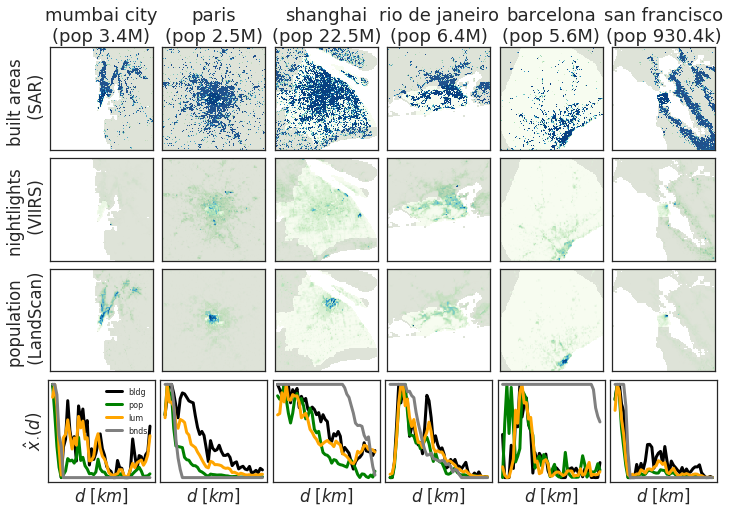

In [41]:
nimg = 6
nrow = 4

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(12,8))
gs1 = gridspec.GridSpec(nrow, nimg)
gs1.update(wspace=0.05, hspace=0.08) # set the spacing between axes. 

for i,(cityname,(v,sample_name)) in enumerate(cities_smpl.iteritems()):
    filename = "%s/%s.tif" % (samples_path, sample_name)
    city_pop = v['population']
    img = read_img(filename)
    waters_mask = img[...,3]==0
    img[waters_mask] = np.nan
    imgSAR_disp = img[...,0]
    imgPOP_disp = img[...,1]
    imgNLI_disp = img[...,2]
    bounds_mask = img[...,4]
    
    # plot built areas
    ax0 = plt.subplot(gs1[0,i]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(imgSAR_disp, bounds_mask>0, ax0); ax0.set_ylabel("built areas \n (SAR)") if i==0 else None
    # plot Nightlights
    ax1 = plt.subplot(gs1[1,i]); ax1.set_xticks([]); ax1.set_yticks([])
    overlay_mask(imgNLI_disp, bounds_mask>0, ax1); ax1.set_ylabel("nightlights \n (VIIRS)") if i==0 else None
    # plot population
    ax2 = plt.subplot(gs1[2,i]); ax2.set_xticks([]); ax2.set_yticks([])
    overlay_mask(imgPOP_disp, bounds_mask>0, ax2); ax2.set_ylabel("population \n (LandScan)") if i==0 else None
    ax0.set_title("%s\n(pop %s)"%(cityname, format_pop(city_pop)))
    # plot profiles
    ax3 = plt.subplot(gs1[3,i]); ax3.set_xticks([]); ax3.set_yticks([])
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = v['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        ax3.plot(distance_km[2:], mu / scale, lw=3, label=s, color=colormap[s])
    if i == 0:
        ax3.set_ylabel("$\hat x_{\cdot}(d)$")
        ax3.legend(loc="best", prop={'size': 8})
    ax3.set_xlabel("$d \ [km]$")    
    

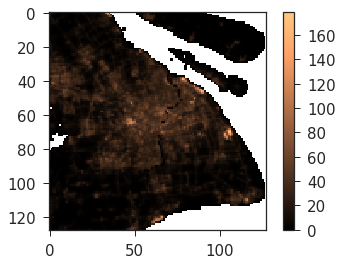

In [95]:
plt.imshow(imgNLI_disp, cmap="copper")
plt.colorbar()

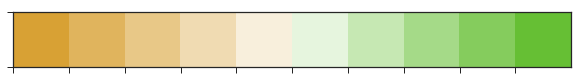

In [57]:
dif_lum_pop_cmap = sns.diverging_palette(55, 120, s=90, l=70, n=20, as_cmap=True)

# bld_cmap = sns.diverging_palette(300, 120, s=90, l=70, n=20, as_cmap=True)
sns.palplot(sns.diverging_palette(55, 120, s=90, l=70, n=10))

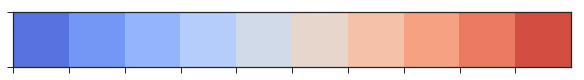

In [122]:
sns.palplot(sns.color_palette("coolwarm", 10))

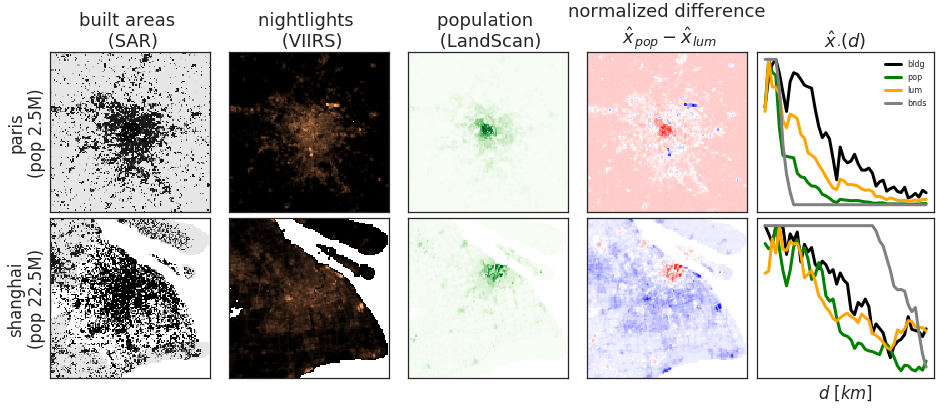

In [119]:
import matplotlib.cm as cm

nimg = 2
ncol = 5

mycities = ['paris', 'shanghai']

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(16,6))
gs1 = gridspec.GridSpec(nimg,ncol)
gs1.update(wspace=0.01, hspace=0.04) # set the spacing between axes. 

for i,cityname in enumerate(mycities):
    v,sample_name = cities_smpl[cityname]
    filename = "%s/%s.tif" % (samples_path, sample_name)
    city_pop = v['population']
    img = read_img(filename)
    waters_mask = img[...,3]==0
    img[waters_mask] = np.nan
    imgSAR_disp = img[...,0]
    imgPOP_disp = img[...,1]
    imgNLI_disp = img[...,2]
    bounds_mask = img[...,4]
    
    # plot built areas
    ax0 = plt.subplot(gs1[i,0]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(imgSAR_disp, bounds_mask>0, ax0, cmap="gray_r"); ax0.set_title("built areas \n (SAR)") if i==0 else None
    # plot Nightlights
    ax1 = plt.subplot(gs1[i,1]); ax1.set_xticks([]); ax1.set_yticks([])
    ax1.imshow(imgNLI_disp, cmap="copper"); ax1.set_title("nightlights \n (VIIRS)") if i==0 else None
    # plot population
    ax2 = plt.subplot(gs1[i,2]); ax2.set_xticks([]); ax2.set_yticks([])
    ax2.imshow(imgPOP_disp,cmap="Greens"); ax2.set_title("population \n (LandScan)") if i==0 else None
    ax0.set_ylabel("%s\n(pop %s)"%(cityname, format_pop(city_pop)))
    
    # plot difference lum - pop
    ax4 = plt.subplot(gs1[i,3]); ax4.set_xticks([]); ax4.set_yticks([])
    ax4.imshow(imgPOP_disp/float(np.nanmax(imgPOP_disp))-imgNLI_disp/float(np.nanmax(imgNLI_disp)),
               cmap="bwr"); 
    ax4.set_title("normalized difference\n $\hat x_{pop}-\hat x_{lum}$") if i==0 else None
    
    
    # plot profiles
    ax3 = plt.subplot(gs1[i,4]); ax3.set_xticks([]); ax3.set_yticks([])
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = v['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        ax3.plot(distance_km[2:], mu / scale, lw=3, label=s, color=colormap[s])
    if i == 0:
        ax3.set_title("$\hat x_{\cdot}(d)$")
        ax3.legend(loc="best", prop={'size': 8})
    ax3.set_xlabel("$d \ [km]$")    
    
    norm = Normalize(vmin=-1,vmax=1)
    for p,q,d in dis_lum_reg:
        ax[1].fill_between(distance_km[p:q], mu_lum[p:q], mu_pop[p:q], 
                             facecolor=cm.ScalarMappable(cmap="bwr").to_rgba(d),
                             interpolate=True, alpha=0.2)


# Analyze variance in profiles ("signal to noise")

There is much more to the spatial distribution of macroeconomic quantities than the simple average profile with distance from the city centre. We analyze how this variance behaves across the world and different continents.

In [ ]:
Vbld = np.vstack([v['profiles']['bldg'][1] for k,v in cities.iteritems()])
Vpop = np.vstack([v['profiles']['pop'][1] for k,v in cities.iteritems()])
Vlum = np.vstack([v['profiles']['lum'][1] for k,v in cities.iteritems()])

Rbld = Vbld / (Xbld)
Rpop = Vpop / (Xpop)
Rlum = Vlum / (Xlum)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(1,3, figsize=(16,4),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=True, sharey=False)

cmap_bld = sns.light_palette("black", n_colors=Rbld.shape[1])
cmap_pop = sns.light_palette("green", n_colors=Rbld.shape[1])
cmap_lum = sns.light_palette("orange",n_colors=Rbld.shape[1])
for i in np.arange(1,Rbld.shape[1],3):
    sns.kdeplot(Rbld[:,i], ax=ax[0], color=cmap_bld[i], label="%d km"%(i*2.86))
    sns.kdeplot(Rpop[:,i], ax=ax[1], color=cmap_pop[i])
    sns.kdeplot(Rlum[:,i], ax=ax[2], color=cmap_lum[i])
    
ax[0].set_title("Building density"); 
ax[1].set_title("Population density")
ax[2].set_title("Luminosity")

ax[0].set_xlabel("$var \ [x_{bld}]/\hat{x}_{bld}(d)$")
ax[1].set_xlabel("$var \ [x_{pop}]/\hat{x}_{pop}(d)$")
ax[2].set_xlabel("$var \ [x_{lum}]/\hat{x}_{lum}(d)$")

fig.subplots_adjust(top=0.75)
plt.suptitle("Variance to mean ratio dependence with distance")

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig, ax = plt.subplots(3,1, gridspec_kw={"wspace":0.03, "hspace":0.15},
                       figsize=(14,10), sharex=True, sharey=True)

for a,R,txt in zip(ax.flatten(), [Rbld,Rpop,Rlum], ["bld", "pop", "lum"]):
    R_df = pd.DataFrame(R)
    R_df['region'] = [v['region'] for k,v in cities_sel.iteritems()]
    R_df['city'] = [v['city'] for k,v in cities_sel.iteritems()]
    R_df = pd.melt(R_df, id_vars=["region", "city"])

    g = sns.boxplot(data=R_df, hue="region", ax=a,
                    y="value", x="variable", showfliers=False)
    _ = g.set_xticklabels(((10*200./286)*np.arange(20)).astype(int), 
                          rotation=90)
    if txt == "lum" : 
        g.set_xlabel("distance from city center $d$ [km]")
    else:
        g.set_xlabel("")
    g.set_ylabel("$var \ [x_{%s}]/\hat{x}_{%s}(d)$" % (txt,txt))
    g.set_title("%s. density" % txt)
    g.legend(loc='upper left', ncol=5)
    # a.annotate("C%d"%c, xy=(-140, -45))
fig.subplots_adjust(top=0.9)
fig.suptitle("Distance dependence of variance to mean ratio")

There is significant variance in the spatial distributions of all three quantities studied. The variance increases with the distance from city center, but there may be many factors as to why that is the case. We don't have data to carefully model every key aspect. Yet, we'd like to be able to perform case studies and scenario analyses with realistic simulations. This suggests that a model with high capacity (a neural network) is suited for such an analysis.

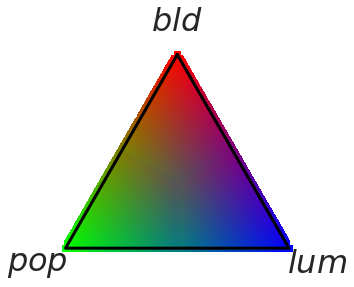

In [44]:
import math

def abc_to_rgb(A=0.0,B=0.0,C=0.0):
    ''' Map values A, B, C (all in domain [0,1]) to
    suitable red, green, blue values.'''
    return (min(A,1.0),min(B,1.0),min(C,1.0))
#     return (min(B+C,1.0),min(A+C,1.0),min(A+B,1.0))

def plot_legend():
    ''' Plots a legend for the colour scheme
    given by abc_to_rgb. Includes some code adapted
    from http://stackoverflow.com/a/6076050/637562'''

    # Basis vectors for triangle
    basis = np.array([[0.0, 1.0], [-1.5/np.sqrt(3), -0.5],[1.5/np.sqrt(3), -0.5]])

    fig = plt.figure()
    ax = fig.add_subplot(111,aspect='equal')

    # Plot points
    a, b, c = np.mgrid[0.0:1.0:50j, 0.0:1.0:50j, 0.0:1.0:50j]
    a, b, c = a.flatten(), b.flatten(), c.flatten()

    abc = np.dstack((a,b,c))[0]
    #abc = filter(lambda x: x[0]+x[1]+x[2]==1, abc) # remove points outside triangle
    abc = map(lambda x: x/sum(x), abc) # or just make sure points lie inside triangle ...

    data = np.dot(abc, basis)
    colours = [abc_to_rgb(A=point[0],B=point[1],C=point[2]) for point in abc]

    ax.scatter(data[:,0], data[:,1],marker=',',edgecolors='none',facecolors=colours)

    # Plot triangle
    ax.plot([basis[_,0] for _ in range(3) + [0,]],[basis[_,1] for _ in range(3) + [0,]],**{'color':'black','linewidth':3})

    # Plot labels at vertices
    offset = 0.25
    fontsize = 32
    ax.text(basis[0,0]*(1+offset), basis[0,1]*(1+offset), '$bld$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)
    ax.text(basis[1,0]*(1+offset), basis[1,1]*(1+offset), '$pop$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)
    ax.text(basis[2,0]*(1+offset), basis[2,1]*(1+offset), '$lum$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)    

    ax.set_frame_on(False)
    ax.set_xticks(())
    ax.set_yticks(())

    plt.show()
    
plot_legend()